In [65]:
using Pkg
Pkg.add("Latexify");
Pkg.add("LaTeXStrings");
Pkg.add("LinearAlgebra");
Pkg.add("JuMP");
Pkg.add("Clp");
Pkg.add("PyPlot");
Pkg.add("NamedArrays")
Pkg.add("CSV");
Pkg.add("DataFrames");
Pkg.add("Ipopt");

  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/

In [110]:
println("Homework 6 - Jacob Lorenz")

Homework 6 - Jacob Lorenz


# Problem 1 - Eclosing Circle

**Given a set of points in the plane $x_i \in \mathcal{R}^2$, we would like to find the circle with smallest possible area that contains all of the points. Explain how to model this as an optimization problem. To test your model, generate a set of 50 random points using the code X = 4 .+ randn(2,50) (this generates a 2×50 matrix X whose columns are the $x_i$). Produce a plot of the randomly generated points along with the enclosing circle of smallest area. Reference the homework write up for starter code.**

At first I thought this problem would be easy as can be. "Smallest circle = largest Euclidean Distance from origin of course." Then I realized that the circle does not have to be centered at the origin, and I then found where the true optimization problem lies.

This problem can be solved in 2 parts. In part one we will find a reasonable starting centroid to use for part 2 of our algorithm. We will do this by finding the center that minimizes the sum of euclidean distances to all of the random points. Although this centroid is not the final centroid, it will reduce the overall number of iterations needed in part 2. In part 2, we will use the starting centroid to iteratively shift the center towards the point with the largest euclidean distance while reducing the radius of the circle that encapsulates all of the random points. This process will be done via iteratively solving a set of convex QP problems.

Let $p_i,q_i$ represent the $x$ and $y$ coordinates of each randomly generated point $i \in [1,50]$, respectively. We let $x$ and $y$ represent the x,y coordinates of the optimal center for the circle, and $R$ represents the radius of the circle in our current iteration. Theoretically, if we assume to know the center of the circle to be the point ($x,y$), then we can model the problem as follows:

$$
    \min_{R} R \\
    \text{subject to:} \\
    \sqrt{(x-p_i)^2 + (y-q_i)^2} \leq R \;\;\;\; \forall i = 1,\dots,50
$$

Next, to turn this into a sequence of convex quadratic problems, we introduce the variable $\theta$ and consider fixed a fixed $R \geq \max (E_i)$ where $E_i$ is the Euclidean distance from the center point ($x,y$). Then we have 

$$
    \min \theta \\
    \text{subject to:} \\
    (x-p_i)^2 + (y-q_i)^2 - \theta \leq R^2 \;\;\;\; \forall i = 1,\dots,50
$$


Furthermore, we will now define one last variable, $z = x^2 + y^2 - \theta$, and reformulate the above problem as:

$$
    \min_{x,y,z} x^2 + y^2 - z \\
    \text{subject to:} \\
    -2p_ix - 2b_iy + z \leq R^2 - p_i^2 - q_i^2 \;\;\;\; \forall i = 1,\dots,50
$$

Our process is then to:
1. Use our starting position of ($x,y$) to compute a value of $R = \max_{i} ( \sqrt{(p_i-x)^2 + (q_i-y)^2} )$
2. Solve the program above to obtain values for $x,y,z$
3. Check if the resulting value of $|x^2 + y^2 - z| \leq \epsilon$ where $\epsilon$ is some error threshold
4. If the threshold is an upper bound, we are done and we have the ($x,y$) and $R$ of our smallest enclosing circle. If the threshold is exceeded, then we use the new values of ($x,y$) to calculate a new value of $R$ and repeat until the threshold holds

In [108]:
using JuMP, Ipopt, Gurobi

# We need to ultimately find the center such that we minimize the furthest 
# Euclidean distance to any point from the center

X = 4 .+ randn(2,50);

# Compute a starting poiint, how about minimizing the sum of Euclidean Distances.

m1 = Model(Ipopt.Optimizer)
# set_optimizer_attribute(m1, "OutputFlag", 0);
@variable(m1, xc);
@variable(m1, yc);
@objective(m1, Min, sum((X[1,i] - xc)^2 + (X[2,i] - yc)^2 for i in 1:size(X,2)))
optimize!(m1)

println("Central Coordinates:") 
println(value.(xc))
println(value.(yc))

centralX = value.(xc)
centralY = value.(yc);

function solveConvexOptimization(R)
    model = Model(Ipopt.Optimizer)
    @variable(model, x)
    @variable(model, y)
    @variable(model, Theta)
    @variable(model, z)
    @constraint(model, z == x^2 + y^2 - Theta)
    
    for i in 1: size(X,2)
        @constraint(model, -2*X[1,i]*x - 2*X[2,i]*y + z <= R^2 - X[1,i]^2 - X[2,i]^2)        
    end
    
    @objective(model, Min, (x^2 + y^2 - z))
    optimize!(model)
        
    return(value.(x), value.(y), value.(z))
end

# Now that we have a reasonable starting point, we need to start the real optimization iteration
iterateFlag = true
ErrorThreshold = 0.00001;
finalRadius = -1
while iterateFlag == true
    maxDistance = 0
    maxDistancePointIndex = -1;
    maxDistanceX = 0
    maxDistanceY = 0
    
    for i in 1:size(X,2)
        curDistanceSquared = (X[1,i] - centralX)^2 + (X[2,i] - centralY)^2
        if (curDistanceSquared > maxDistance)
           maxDistance = curDistanceSquared
            maxDistanceX = X[1,i]
            maxDistanceY = X[2,i]
            maxDistancePointIndex = i
        end
    end
    
    # We now have a radius to try using for the next iteration of optimization
    curRadius = sqrt(maxDistance)
    (x,y,z) = solveConvexOptimization(curRadius)
    if abs(x^2 + y^2 - z) <= ErrorThreshold
        iterateFlag = false
        centralX = x    
        centralY = y
        finalRadius = curRadius
    else
        centralX = x    
        centralY = y
    end
end


This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

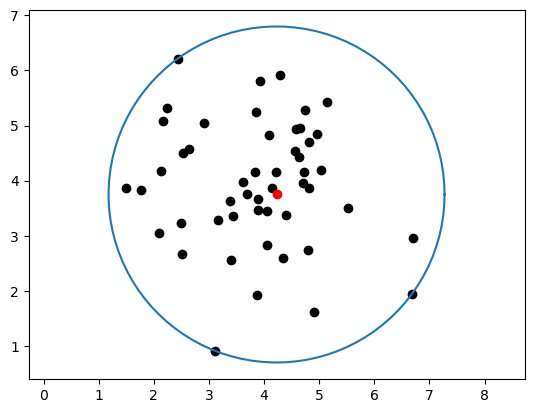

In [109]:
using PyPlot

t = range(0,stop=2π,length=100);
axis("equal");

# two vectors of random numbers(normal distribution)
# randX = randn(1, 50);
# randY = randn(1, 50);

# draw random scatter points
scatter(X[1,:], X[2,:], color="black");

# draw a circle
r = finalRadius;
cx = centralX;
cy = centralY;
plot( cx .+ r *cos.(t),cy .+ r * sin.(t));

# draw the center of the circle
scatter(cx, cy, color="red");

# Problem 2 - Quadratic Form Positivity

**You're presented with the constraint:**

$$
    2x^2 + 2y^2 + 9z^2 + 8xy - 6xz - 6yz \leq 1
$$

**a) Write the constraint (1) in the standard form $v^TQv \leq 1$. Where $Q$ is a symmetric matrix. What is $Q$ and what is $v$?**

When we go to create the Q symmetric matrix, the first thing we notice is the diagonals on the squared terms. After this, we notice the mixed terms all have even coefficients, and so we can split their values along the transpose line.

$$
    Q = \left[ \begin{array}{rl}
                2 \\
                4 \\
                -3 \\
            \end{array} \right.
            \left. \begin{array}{rl}
                4 \\
                2 \\
                -3 \\
            \end{array} \right. 
            \left. \begin{array}{rl}
                -3 \\
                -3 \\
                9 \\
            \end{array}\right], \;\;\;
    v = \left[ \begin{array}{rl}
                x \\
                y \\
                z \\
            \end{array}\right] \;\;\;
$$

Therefore, constraint (1) can be written as:

$$
    \left[ \begin{array}{rl}
                x \\
                y \\
                z \\
            \end{array}\right]^T *\;
            \left[ \begin{array}{rl}
                2 \\
                4 \\
                -3 \\
            \end{array} \right.
            \left. \begin{array}{rl}
                4 \\
                2 \\
                -3 \\
            \end{array} \right. 
            \left. \begin{array}{rl}
                -3 \\
                -3 \\
                9 \\
            \end{array}\right] * \;
            \left[ \begin{array}{rl}
                x \\
                y \\
                z \\
            \end{array}\right] \leq 1
$$


**b) It turns out the above constraint is not convex. In other words, the set of $(x, y, z)$ satisfying the constraint (1) is not an ellipsoid. Explain why this is the case.**

**Note: you can perform an orthogonal decomposition of a symmetric matrix Q in Julia like this:**

       (Lambda,U) = eigen(Q)    # Lambda is the vector of eigenvalues and U is orthogonal
       U * diagm(Lambda) * U’   # this is equal to Q (as long as Q was symmetric to begin with)

In [85]:
using JuMP
using LinearAlgebra

Q = [ 2 4 -3; 4 2 -3; -3 -3 9 ]

(Lambda,U) = eigen(Q)    # Lambda is the vector of eigenvalues and U is orthogonal
# U * diagm(Lambda) * U’   # this is equal to Q (as long as Q was symmetric to begin with)


Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
values:
3-element Array{Float64,1}:
 -1.9999999999999996
  3.000000000000001
 12.0
vectors:
3×3 Array{Float64,2}:
  0.707107  -0.57735  -0.408248
 -0.707107  -0.57735  -0.408248
  0.0       -0.57735   0.816497

In the above quadratic equation, we see the eigenvalues are -1.999.., 3, and 12. Since there are a mix of positive and negative eigenvalues, the Symmetric Matrix Q is indefinite, and as such, the constraint associated with the Symmetric Matrix Q is not an ellipsoid. This stems from the conical form of an ellipsoid:

$$
    \frac{x_1^2}{c_1^2} + \dots + \frac{x_n^2}{c_n^2} = 1
$$

where $c_i = \frac{1}{\lambda_i}$ and $\lambda_i$ is the $i^{th}$ eigenvalue. Since we have a negative eigenvalue, -1.999..., this will lead to having to take the root of a negative number resulting in a complex number. Rather than an ellipsoid, this constraint results in a non-convex hyperboloid.

**c) We can also write the constraint (1) using norms by putting it in the form: $$||Av||^2 - ||Bv||^2 \leq 1$$ What is $v$ and what are the matrices $A$ and $B$ that make the constraint above equivalent to (1)?**

Similar to part a), v is our variable vector:

$$
    v = \left[ \begin{array}{rl}
                x \\
                y \\
                z \\
            \end{array}\right] \;\;\;
$$

After performing the eigendecomposition, we can see that our eigenvalues are ~ -2, 3, and 12. Additionally, we know the following results about positive semidefinite matrices. Let

$$
    Q = U \Lambda U^T \;\;\; \text{be an orthogonal decomposition} \\
    \Lambda^{1/2} = diag(\sqrt{\lambda_1},\dots,\sqrt{\lambda_n})
$$

Then, we can define the matrix square root as:

$$
    Q^{1/2} = U\Lambda^{1/2}U^T
$$

Therefore, 

$$
    x^TQx \leq b <--> \|Q^{1/2}x\|^2 \leq b
$$ 

Then, given our eigenvalues and the above result, we can group the positive eigenvalue terms into the A matrix, and the negative eigenvalue terms into the B matrix. Let

$$
    U = \left[ \begin{array}{rl}
                .707107 \\
                 -.707107 \\
                 0 \\
            \end{array} \right.
            \left. \begin{array}{rl}
                -.57735 \\
                -.57735 \\
                -.57735 \\
            \end{array} \right. 
            \left. \begin{array}{rl}
                 - .408248 \\
                 - .408248\\
                 .816497 \\
            \end{array}\right] 
$$

Then,

$$
    A = U * 
    \left[ \begin{array}{rl}
                 0 \\
                 0 \\
                 0 \\
            \end{array} \right.
            \left. \begin{array}{rl}
                0 \\
                \sqrt{3} \\
                0 \\
            \end{array} \right. 
            \left. \begin{array}{rl}
                 0 \\
                 0\\
                 \sqrt{12} \\
            \end{array}\right] * U^T \\
$$

And 

$$
    B = U * 
    \left[ \begin{array}{rl}
                 \sqrt{2} \\
                 0 \\
                 0 \\
            \end{array} \right.
            \left. \begin{array}{rl}
                0 \\
                0 \\
                0 \\
            \end{array} \right. 
            \left. \begin{array}{rl}
                 0 \\
                 0\\
                 0 \\
            \end{array}\right] * U^T
$$

After solving, we have:

$$
    A = \left[ \begin{array}{rl}
                 1.1547 \\
                 1.1547 \\
                 -.57735 \\
            \end{array} \right.
            \left. \begin{array}{rl}
                1.1547 \\
                1.1547 \\
                -.57735 \\
            \end{array} \right. 
            \left. \begin{array}{rl}
                 -.57735 \\
                 -.57735\\
                 2.88675 \\
            \end{array}\right] \\
$$

$$
    B = \left[ \begin{array}{rl}
                 .707107 \\
                 -.707107 \\
                 0 \\
            \end{array} \right.
            \left. \begin{array}{rl}
                -.707107 \\
                .707107 \\
                0 \\
            \end{array} \right. 
            \left. \begin{array}{rl}
                 0 \\
                 0 \\
                 0 \\
            \end{array}\right] \\
$$

**d) Explain how to find (x, y, z) that satisfies the constraint (1) and that has arbitrarily large magnitude (i.e. $x^2 + y^2 + z^2$ is as large as you like).**

The process of generalizing the values of $x,y,x$ to an arbitrary magnitude while still maintaining the constraint involves a few steps, some of which we have covered in parts a, b, and c.
1. Find the symmetric matrix $Q$ which represents the constraint in the form of $x^TQx \leq b$
2. Find the eigendecomposition of the symmetric matrix Q such that $Q = U\Lambda U$
3. Find an equivalent constraint by changing coordinates into $[p,q,r]$ such that 

$$
    \left[ \begin{array}{rl}
                p \\
                q \\
                r \\
            \end{array}\right] = U^Tx
$$
4. Making these substitutions, we then have the equivalent constraint of:

$$
    \lambda_pp^2 + \lambda_qq^2 + \lambda_rr^2 = 3q^2 + 12r^2 - 2p^2 \leq 1
$$

Where

$$
    p = .707x -.707y \\
    q = -.577x - .577y - .577z \\
    r = -.408x - .408y + .810z
$$

5. Fix $x$ and $y$ to an arbitrary value and solve the inequality to obtain an expression for z
6. Scale $x$ and $y$ to whatever magnitude you would like and use the expression found in step 5. to obtain a range of values for z that will still satisfy the constraint

After performing the steps above and solving the inequality to obtain an algebraic expression for z, we have the following:

Fix $x$ and $y$ at whatever magnitude you want such that $x = x_F$ and $y = y_F$. Then,

$$
    z \leq \frac{\sqrt{1 + (.8786803x_F + .8786803y_F)^2 + .970478x_Fy_F} + 1.663952(x_F + y_F)}{\sqrt{8.8719872}}
$$

Thus, any $z$ that abides by the inequality directly above will ensure that an arbitrary choice of $x$ and $y$ will still satisfy the original constraint.

# Problem 3 - Lasso Regression

**Consider the data (x,y) available in lasso_data.csv. In this problem you will investigate different approaches for performing polynomial regression.**

**a) Perform ordinary polynomial regression. Make plots that show the data as well as the best fit to the data for polynomials of degree $d = 5$ and $d = 15$. Also comment on the magnitudes of the coefficients in the resulting polynomial fits. Are they small or large?**

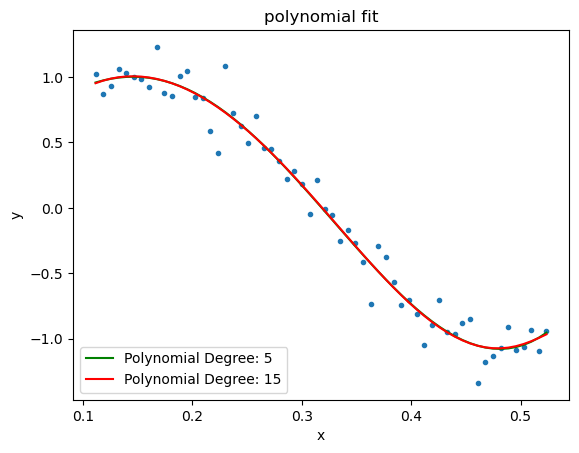

Academic license - for non-commercial use only - expires 2021-05-01
Academic license - for non-commercial use only - expires 2021-05-01

Optimal Objective Value for Degree 5 Polynomial: 1.0139930955322924
Best Fitting Degree 5 Polynomial: -247.38754848164047x^5 + 495.9334905147239x^4 + -254.14156525670447x^3 + 16.757301267295865x^2 + 5.737209163628612x + 0.389894548736443

Optimal Objective Value for Degree 15 Polynomial: 1.0127159728599295
Best Fitting Degree 15 Polynomial: -242527.03477893778x^15 + 168342.11894680077x^14 + 49681.04656963775x^13 + -15447.523029748663x^12 + -17986.26535477522x^11 + -5646.426512368982x^10 + 1404.521133208141x^9 + 2198.048913110235x^8 + 754.7901116784483x^7 + -176.43907548530822x^6 + -270.3962503635232x^5 + 25.603188740712973x^4 + 95.44514975136761x^3 + -80.7210386246529x^2 + 17.727076118318568x + -0.15189967143668667


In [81]:
using PyPlot, CSV, DataFrames, JuMP, Gurobi

data = CSV.read("lasso_data.csv", DataFrame)
x = data[:,1]
y = data[:,2]

# D = degree of the polynomial, λ = regularization weight
function solveOrdinaryPolynomialRegression(D,λ)
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", 0);
    
    # We need variables that represent the coefficients of all degrees
    @variable(model, u[1:D+1]);
    
    # Create the A matrix using the data provided
    n = length(x)
    A = zeros(n, D+1)
    for i = 1:n
       for j = 1:D+1
           A[i,j] = x[i]^(D+1-j) 
        end
    end
    
    # Define the expressions for OLS and L2N
    @expression(model, OrdinaryLS, sum( (y-A*u).^2 ) )
    @expression(model, L2Norm, sum( (u).^2 ) )
    
    # The objective is a tradeoff between the OLS and L2N expressions
    @objective(model, Min, OrdinaryLS + λ * L2Norm)
    
    # Solve
    optimize!(model)
    uopt = value.(u)
    objValue = objective_value(model)
    return(uopt, objValue)
end


# Plot the Data and the Results from Regression
# =============================================

plot(x, y, ".");
xlabel("x"); ylabel("y");
n=size(data, 1);

D5 = 5
D15 = 15
λ = 0
(uopt, objVal) = solveOrdinaryPolynomialRegression(D5,λ)
(uopt2, objVal2) = solveOrdinaryPolynomialRegression(D15,λ)

xVals = x[:,1]
yVals5 = uopt[1] * xVals.^5 + uopt[2] * xVals.^4 + uopt[3] * xVals.^3 + uopt[4] * xVals.^2 + uopt[5] * xVals .+ uopt[6]
yVals15 = uopt2[1] * xVals.^15 + uopt2[2] * xVals.^14 + uopt2[3] * xVals.^13 + uopt2[4] * xVals.^12 + uopt2[5] * xVals.^11 + uopt2[6] * xVals.^10 + uopt2[7] * xVals.^9 + uopt2[8] * xVals.^8 + uopt2[9] * xVals.^7 + uopt2[10] * xVals.^6 + uopt2[11] * xVals.^5 + uopt2[12] * xVals.^4 + uopt2[13] * xVals.^3 + uopt2[14] * xVals.^2 + uopt2[15] * xVals.^1 .+ uopt2[16]

plot(xVals, yVals5, "g-", label = "Polynomial Degree: 5" )
plot(xVals, yVals15, "r-", label = "Polynomial Degree: 15")
title("polynomial fit")
legend(loc = "lower left")

println()
println("Optimal Objective Value for Degree 5 Polynomial: ", objVal)
println("Best Fitting Degree 5 Polynomial: ", uopt[1], "x^5 + ", uopt[2], "x^4 + ", uopt[3], "x^3 + ", uopt[4], "x^2 + ", uopt[5], "x + ", uopt[6])
println()
println("Optimal Objective Value for Degree 15 Polynomial: ", objVal2)
println("Best Fitting Degree 15 Polynomial: ", uopt2[1], "x^15 + ", uopt2[2], "x^14 + ", uopt2[3], "x^13 + ", uopt2[4], "x^12 + ", uopt2[5], "x^11 + ", uopt2[6], "x^10 + ", uopt2[7], "x^9 + ", uopt2[8], "x^8 + ", uopt2[9], "x^7 + ", uopt2[10], "x^6 + ", uopt2[11], "x^5 + ", uopt2[12], "x^4 + ", uopt2[13], "x^3 + ", uopt2[14], "x^2 + ", uopt2[15], "x + ", uopt2[16])


The magnitudes of the coefficients for the degree 5 polynomial, as displayed in the results above, were quite large. The 3 highest order coefficients were on the scale of $10^2$, and the 3 smallest degree coefficients ranged from the scale of $10^1$ to $10^{-1}$. This is rather curious since the values of y range primarily between -1 and 1.

For the degree 15 polynomial, things get even more out of hand. The coefficients range in value, from a magnitude of $10^5$ to $10^{-1}$, again, with the highest order coefficients taking on the highest magnitudes.

When I think about it though, I can understand why this is the case. It's easy to look at those coefficients and say they blow the range of y values out of the water; however, the range of x values is from around $.1$ to $.5$, and so when you have higher order polynomials they take on extremely small values, not large. So the highest order terms need very large coefficients to have that term impact the overall curve in the slightest.

**b) In order to get smaller coefficients, we will use ridge regression ($L_2$ regularization). Re-solve the $d = 15$ version of the problem using a regularization parameter $λ = 10^{−6}$ and plot the new fit. How does the fit change compared to the non-regularized case of part a? How do the magnitudes of the coefficients in the resulting polynomial fit change?**

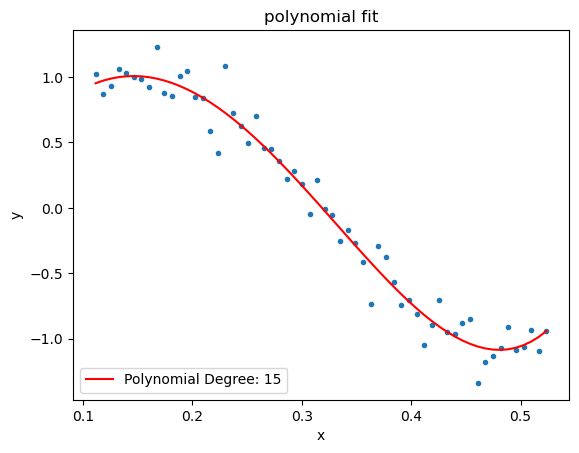

Academic license - for non-commercial use only - expires 2021-05-01

Optimal Objective Value for Degree 15 Polynomial: 1.0223289483000713
Best Fitting Degree 15 Polynomial: -0.5679921994103718x^15 + -0.9343076244715509x^14 + -1.4897195136075188x^13 + -2.275811215028808x^12 + -3.26772544987577x^11 + -4.254679599913573x^10 + -4.623007749920358x^9 + -3.0573005424552435x^8 + 2.6213213113524465x^7 + 14.70833112014038x^6 + 32.191466234715215x^5 + 42.673656994304515x^4 + 15.587427299352239x^3 + -58.095084056069126x^2 + 15.381451634969174x + -0.06951753070778098


In [82]:
λ2 = 10^-6
(uopt3, objVal3) = solveOrdinaryPolynomialRegression(D15,λ2)

xVals = x[:,1]
yVals15_reg = uopt3[1] * xVals.^15 + uopt3[2] * xVals.^14 + uopt3[3] * xVals.^13 + uopt3[4] * xVals.^12 + uopt3[5] * xVals.^11 + uopt3[6] * xVals.^10 + uopt3[7] * xVals.^9 + uopt3[8] * xVals.^8 + uopt3[9] * xVals.^7 + uopt3[10] * xVals.^6 + uopt3[11] * xVals.^5 + uopt3[12] * xVals.^4 + uopt3[13] * xVals.^3 + uopt3[14] * xVals.^2 + uopt3[15] * xVals.^1 .+ uopt3[16]

# Plot the Data and the Results from Regression
# =============================================

plot(x, y, ".");
xlabel("x"); ylabel("y");
n=size(data, 1);

plot(xVals, yVals15_reg, "r-", label = "Polynomial Degree: 15")
title("polynomial fit")
legend(loc = "lower left")

println()
println("Optimal Objective Value for Degree 15 Polynomial: ", objVal3)
println("Best Fitting Degree 15 Polynomial: ", uopt3[1], "x^15 + ", uopt3[2], "x^14 + ", uopt3[3], "x^13 + ", uopt3[4], "x^12 + ", uopt3[5], "x^11 + ", uopt3[6], "x^10 + ", uopt3[7], "x^9 + ", uopt3[8], "x^8 + ", uopt3[9], "x^7 + ", uopt3[10], "x^6 + ", uopt3[11], "x^5 + ", uopt3[12], "x^4 + ", uopt3[13], "x^3 + ", uopt3[14], "x^2 + ", uopt3[15], "x + ", uopt3[16])

In this case of Ridge Regression, visually the fit does not look really any different. The curve still generally tracks nicely with the contours of the data. Quantitatively, the ridge regression objective value is .009612975 units of error higher than the non regularized version.

Looking at the coefficients; however, we see a massive difference. Now, instead of having many magnitudes of $10^5$ or $10^4$, we see the largest coefficient has a magnitude of $10^1$ and they are much more evenly distributed along each of the polynomial orders.

**c) Our model is still complicated because it has so many parameters. One way to simplify our model is to look for a sparse model (where many of the parameters are zero). Solve the $d = 15$ problem once more, but this time use the Lasso ($L_1$ regularization). Start with a large λ and progressively make λ smaller until you obtain a model with a small number of parameters that fits the data reasonably well. Note: due to numerical inaccuracy in the solver, you may need to round very small coefficients (say less than $10^{−5}$) down to zero. Plot the resulting fit.**

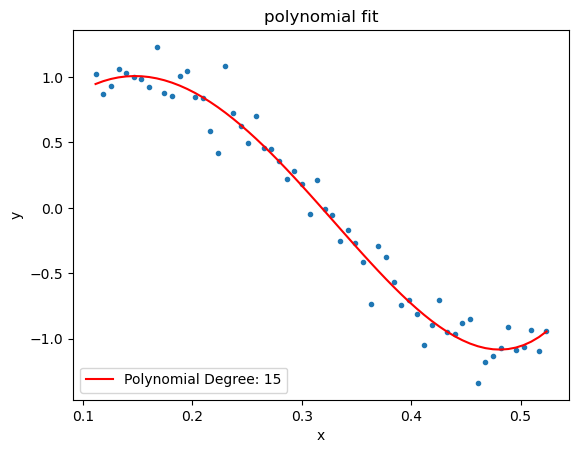

Academic license - for non-commercial use only - expires 2021-05-01

Optimal Objective Value for Degree 15 Polynomial: 1.0166028855780525
Best Fitting Degree 15 Polynomial: 0.0x^15 + 0.0x^14 + 0.0x^13 + 0.0x^12 + 0.0x^11 + 0.0x^10 + 0.0x^9 + 0.0x^8 + 0.0x^7 + 0.0x^6 + 12.497060503372445x^5 + 79.5595829878927x^4 + 0.0x^3 + -56.51041506702345x^2 + 15.62564804705139x + -0.10585860798049984


In [83]:
function solveOrdinaryPolynomialRegressionL1(D,λ)
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", 0);
    # We need variables that represent the coefficients of all degrees
    @variable(model, u[1:D+1])
    @variable(model, t[1:D+1])
    
    # Create the A matrix using the data provided
    n = length(x)
    A = zeros(n, D+1)
    for i = 1:n
       for j = 1:D+1
           A[i,j] = x[i]^(D+1-j) 
        end
    end
    
    # Define the expressions for OLS and L1N
    @expression(model, OrdinaryLS, sum( (y-A*u).^2 ) )
    @expression(model, L1Norm, sum(t[i] for i in 1:D+1) )
    
    # Define constraints to handle the conversion from absolute value
    for i in 1:D+1
       @constraint(model, t[i] >= u[i]) 
       @constraint(model, t[i] >= -1*u[i]) 
    end
    
    # The objective is a tradeoff between the OLS and L1N expressions
    @objective(model, Min, OrdinaryLS + λ * L1Norm)
    
    # Solve
    optimize!(model)
    uopt = value.(u)
    
    # Round small weights
    for i in 1:D+1
       if (abs(uopt[i]) < 10^-5)
           uopt[i] = 0;
        end
    end
    
    objValue = objective_value(model)
    return(uopt, objValue)
end


# Plot the Data and the Results from Regression
# =============================================

plot(x, y, ".");
xlabel("x"); ylabel("y");
n=size(data, 1);

D15 = 15
λ = 10^-5
(uopt4, objVal4) = solveOrdinaryPolynomialRegressionL1(D15,λ)

xVals = x[:,1]
yVals15_L1 = uopt4[1] * xVals.^15 + uopt4[2] * xVals.^14 + uopt4[3] * xVals.^13 + uopt4[4] * xVals.^12 + uopt4[5] * xVals.^11 + uopt4[6] * xVals.^10 + uopt4[7] * xVals.^9 + uopt4[8] * xVals.^8 + uopt4[9] * xVals.^7 + uopt4[10] * xVals.^6 + uopt4[11] * xVals.^5 + uopt4[12] * xVals.^4 + uopt4[13] * xVals.^3 + uopt4[14] * xVals.^2 + uopt4[15] * xVals.^1 .+ uopt4[16]

plot(xVals, yVals15_L1, "r-", label = "Polynomial Degree: 15")
title("polynomial fit")
legend(loc = "lower left")

println()
println("Optimal Objective Value for Degree 15 Polynomial: ", objVal4)
println("Best Fitting Degree 15 Polynomial: ", uopt4[1], "x^15 + ", uopt4[2], "x^14 + ", uopt4[3], "x^13 + ", uopt4[4], "x^12 + ", uopt4[5], "x^11 + ", uopt4[6], "x^10 + ", uopt4[7], "x^9 + ", uopt4[8], "x^8 + ", uopt4[9], "x^7 + ", uopt4[10], "x^6 + ", uopt4[11], "x^5 + ", uopt4[12], "x^4 + ", uopt4[13], "x^3 + ", uopt4[14], "x^2 + ", uopt4[15], "x + ", uopt4[16])


In the results for Lasso regularization, we tried a number of different values for λ, and I believe that $10^{-5}$ provides the right balance of good objective performance (1.0166 error) and sparsity (5 nonzero terms).

The sparsified soltuion came to be an order 5 polynomial:

$$
    12.4970605x^5 + 79.55958x^4 - 56.51041x^2 + 15.62565x -.1058586
$$

This result is interesting, because it suggests that when we give a little reward for not overfitting the data, the result is a polynomial of degree 5 with good performance, suggesting that a degree 5 polynomial is perhaps a more efficient order for fitting the curve.